# Graph 

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
import matplotlib.pyplot as plt

# Detect environment

In [2]:
from pkg.marker_config import *
from pkg.environment_builder import *
from pkg.geometry import *
from pkg.utils import *

init_stereo()
aruco_map, dictionary = get_aruco_config()

ROBOTS_ON_SCENE = [("indy0", RobotType.indy7_robot), ("panda1", RobotType.panda_robot)]
JOINT_NAMES_DEFINED = ['indy0_joint0', 'indy0_joint1', 'indy0_joint2', 'indy0_joint3', 'indy0_joint4', 'indy0_joint5',
                   'panda1_joint1', 'panda1_joint2', 'panda1_joint3', 'panda1_joint4', 
                   'panda1_joint5', 'panda1_joint6', 'panda1_joint7']
ZERO_JOINT_POSE=np.array([0,0,-np.pi/2,0,-np.pi/2,0,
                          0,-np.pi/8,0,-np.pi/2,0,np.pi/2,np.pi/2])

Start streaming
Device configuration: 
	color_format: 3 
	(0:JPG, 1:NV12, 2:YUY2, 3:BGRA32)

	color_resolution: 5 
	(0:OFF, 1:720p, 2:1080p, 3:1440p, 4:1536p, 5:2160p, 6:3072p)

	depth_mode: 3 
	(0:OFF, 1:NFOV_2X2BINNED, 2:NFOV_UNBINNED,3:WFOV_2X2BINNED, 4:WFOV_UNBINNED, 5:Passive IR)

	camera_fps: 2 
	(0:5 FPS, 1:15 FPS, 2:30 FPS)

	synchronized_images_only: False 
	(True of False). Drop images if the color and depth are not synchronized

	depth_delay_off_color_usec: 0 ms. 
	Delay between the color image and the depth image

	wired_sync_mode: 0
	(0:Standalone mode, 1:Master mode, 2:Subordinate mode)

	subordinate_delay_off_master_usec: 0 ms.
	The external synchronization timing.

	disable_streaming_indicator: False 
	(True or False). Streaming indicator automatically turns on when the color or depth camera's are in use.




In [3]:
kn_config, rs_config, T_c12 = calibrate_stereo(aruco_map, dictionary)

xyz_rpy_robots, xyz_rvec_cams, env_gen_dict, objectPose_dict, corner_dict, color_image  = \
    detect_environment(
        aruco_map, dictionary, robot_tuples=ROBOTS_ON_SCENE,
        env_dict={'floor': CallHolder(GeoBox, ["center", "orientation"], BLH=(1.52,0.72,0.01)), 
                  'wall':CallHolder(GeoBox, ["center", "orientation"], BLH=(3,3,0.01))},  
        camT_dict={"cam0":np.identity(4), "cam1": T_c12}, 
        ref_name='floor')

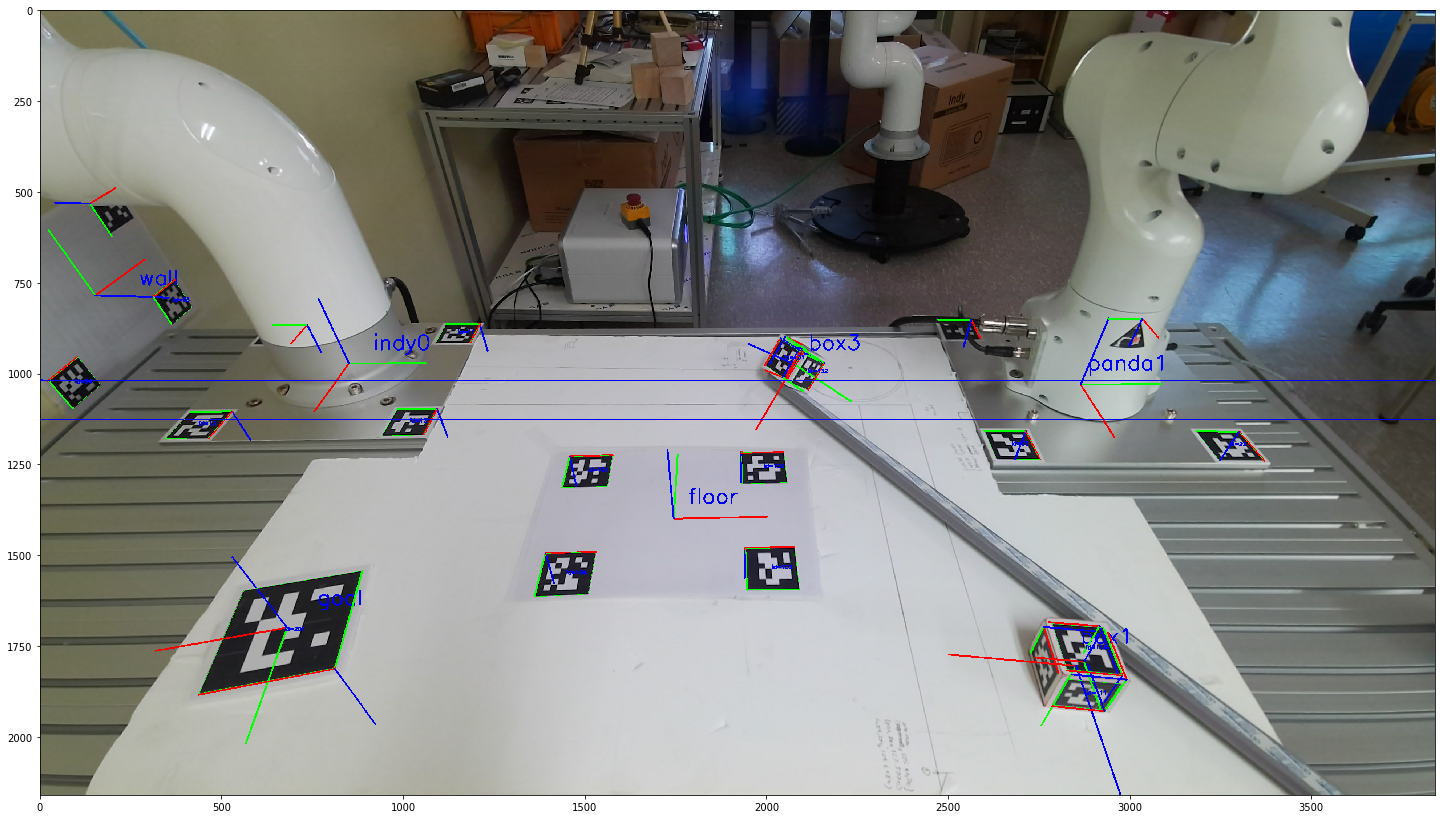

In [4]:
plt.figure(figsize=(25,15))
color_image_out = draw_objects(color_image, aruco_map, objectPose_dict, corner_dict, *kn_config, axis_len=0.1)
plt.imshow(color_image_out[:,:,[2,1,0]])

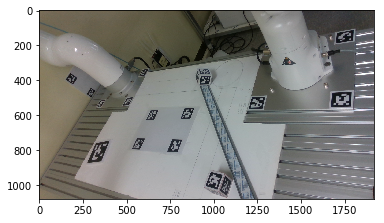

In [5]:
plt.imshow(get_rs_image()[:,:,[2,1,0]])

In [6]:
# with open('config.pkl', 'wb') as f:
#     pickle.dump({"objectPose_dict":objectPose_dict, "corner_dict":corner_dict}, f)

In [7]:
# disconnRobotType.indy7_robotect_stereo()

# Define robot config

In [8]:
urdf_content = None
from pkg.robots_custom import *
xcustom = XacroCustomizer(ROBOTS_ON_SCENE, xyz_rpy_robots)

vel_scale, acc_scale = 0.5, 0.5
custom_limits = {}
XacroCustomizer.update_limit_dict(custom_limits, "vel", JOINT_NAMES_DEFINED, 
                                  vel_scale * np.deg2rad(
        [150, 150, 150, 180, 180, 180, 150, 150, 150, 150, 180, 180, 180]))
XacroCustomizer.update_limit_dict(custom_limits, "acc", JOINT_NAMES_DEFINED, 
                                  acc_scale * np.deg2rad(
        [360]*len(JOINT_NAMES_DEFINED)))
custom_limits['panda1_joint1']['lower'], custom_limits['panda1_joint1']['upper'] = -2.75, 2.75
custom_limits['panda1_joint2']['lower'], custom_limits['panda1_joint2']['upper'] = -1.70, 1.70
custom_limits['panda1_joint3']['lower'], custom_limits['panda1_joint3']['upper'] = -2.75, 2.75
custom_limits['panda1_joint4']['lower'], custom_limits['panda1_joint4']['upper'] = -2.9, -0.1
custom_limits['panda1_joint5']['lower'], custom_limits['panda1_joint5']['upper'] = -2.75, 2.75
custom_limits['panda1_joint6']['lower'], custom_limits['panda1_joint6']['upper'] = 0.1, 3.6
custom_limits['panda1_joint7']['lower'], custom_limits['panda1_joint7']['upper'] = -2.75, 2.75


JOINT_NAMES, LINK_NAMES, urdf_content = \
        xcustom.convert_xacro_to_urdf(
        joint_fix_dict={'finger':'upper'},
        joint_offset_dict={},
        joint_limit_dict=custom_limits)
refine_meshes()
xcustom.start_rviz()

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


# Create Graph

In [9]:
from pkg.constraint_graph import *
from pkg.constants import *
from pkg.plot_utils import *
from pkg.utils import *

rospy.init_node('task_planner', anonymous=True)

In [10]:
gtimer = GlobalTimer.instance()
gtimer.reset()
graph = ConstraintGraph(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, urdf_content=urdf_content,
                       connect_panda = False, connect_indy = False)
col_items_dict = graph.set_fixed_geometry_items(
    get_geometry_items_dict(graph.urdf_content, color=(0,1,0,0.3), display=True, collision=True, 
                             exclude_link=["panda1_link7"]))

add_cam_poles(graph, xyz_rvec_cams)
add_objects_gen(graph, env_gen_dict)

if graph.connect_indy:
    graph.indy.connect_and(graph.indy.joint_move_to,np.rad2deg(ZERO_JOINT_POSE[graph.indy_idx]))
if graph.connect_panda:
    graph.panda.move_joint_interpolated(ZERO_JOINT_POSE[graph.panda_idx], N_div=300)
    graph.panda.set_k_gain(70)
    graph.panda.set_d_gain(7)

## add custom meshes

In [11]:
graph.add_geometry_items([
                           GeoMesh(uri="package://my_mesh/meshes/stl/end_tool_asm2_ctd.stl", BLH=(0.01,0.01,0.01), orientation_mat=Rot_axis(3,np.pi*2/16), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="indy0_tcp", 
                                   urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1), collision=False),
                           GeoBox((0, 0,0.0675), (0.05,0.05,0.130), orientation=(0,0,0), 
                                  name="gripper1_col", link_name="indy0_tcp", urdf_content=graph.urdf_content, color=(0,1,0,0.3), collision=True),
                           GeoSegment((-0.1,0,0.03), (0,np.pi/2,0), 0.2, 0.05, name="indy0_plug", link_name="indy0_link0",
                                      urdf_content=graph.urdf_content, color=(0,1,0,0.3), display=True, collision=True),
                           GeoSegment((-0.05,0,0.03), (np.pi/2,0.0,0.0), 0.3, 0.05, name="cableset", link_name="panda1_link0", 
                                      urdf_content=graph.urdf_content, color=(0,1,0,0.3), display=True, collision=True)
    ], fixed=True)

## Register binders

In [12]:
graph.register_binder(name='grip1', _type=VacuumTool, point=[0,-2.5e-2,112e-3], link_name="panda1_hand", direction=[0,1,0])
graph.register_binder(name='vac2', _type=VacuumTool, point=(0, 0,0.132), link_name="indy0_tcp", direction=[0,0,1])
graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])

# Add objects

In [13]:
MOVABLE_GENERATORS = {'box1': CallHolder(GeoBox, ["center", "orientation"], BLH=(0.05, 0.05,0.05), color=(0.8,0.3,0.3,1)), 
                 'box2': CallHolder(GeoBox, ["center", "orientation"], BLH=(0.05, 0.05,0.05), color=(0.3,0.3,0.8,1)), 
                 'box3': CallHolder(GeoSphere, ["center", None], radius=0.15, color=(0.8,0.8,0.0,0.3), collision=False), 
                 'goal': CallHolder(GeoBox, ["center", "orientation"], BLH=(0.1, 0.1,0.01), color=(0.8,0.0,0.0,1))}
BINDER_DICT = {'goal_bd': dict(_type=PlacePlane, object_name="goal", point=[0,0,0.008], direction=[0,0,1])}
OBJECT_DICT = {'box1': dict(_type=BoxAction, hexahedral=True),
               'box2': dict(_type=BoxAction, hexahedral=True)}

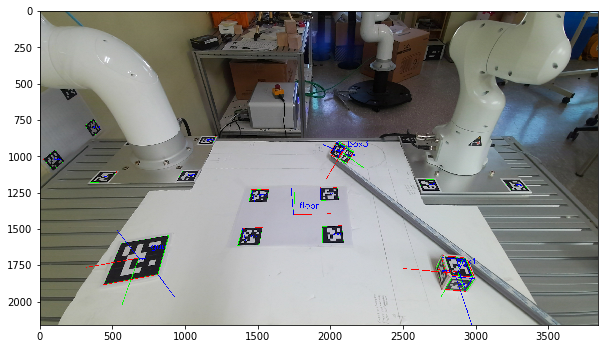

In [14]:
objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
    detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
put_point_dict = register_objects(graph, objectPose_dict_mv, MOVABLE_GENERATORS, BINDER_DICT, OBJECT_DICT, 
                 ref_tuple=("floor", objectPose_dict["floor"]), link_name="world")

plt.figure(figsize=(10,8))
aruco_map_mv.update({'floor': aruco_map['floor']})
color_image_out = draw_objects(color_image, aruco_map_mv, objectPose_dict_mv, corner_dict_mv, *kn_config, axis_len=0.1)
plt.imshow(color_image_out[:,:,[2,1,0]])

# Set RVIZ

In [15]:
gtimer.tic("set_sim")
graph.set_simulation(nWSR=300, regularization_factor= 1e-6)
gtimer.toc("set_sim")
# graph.show_pose(ZERO_JOINT_POSE, execute=True)
if graph.connect_indy and graph.connect_panda:
    graph.show_pose(graph.get_real_robot_pose())
else:
    graph.show_pose(ZERO_JOINT_POSE)
    

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


# Search Graph (Custom Robots)

In [16]:
graph.build_graph()

In [17]:
objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
    detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
objectPose_dict_mv.update({'floor': objectPose_dict['floor']})
xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
    objectPose_dict_mv, MOVABLE_GENERATORS, OBJECT_DICT, ("floor", objectPose_dict["floor"]))
update_geometries(MOVABLE_GENERATORS.keys(), objectPose_dict_mv)
graph.show_pose(ZERO_JOINT_POSE)

In [18]:
dt_sim = 0.04
T_step = 10
N_fullstep = int(T_step / dt_sim)
gtimer.reset()
initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                      {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                      (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                       else ZERO_JOINT_POSE))

goal_nodes = get_goal_nodes(initial_state, "box1", "goal_bd")
goal_nodes = goal_nodes[3:4]

graph.search_graph_mp(
    initial_state = initial_state, goal_nodes = goal_nodes,
    tree_margin = 2, depth_margin = 2, joint_motion_num=20, 
    terminate_on_first = True, N_search = 100, N_loop=1000,
    display=False, dt_vis=dt_sim/40, verbose = True, print_expression=False, error_skip=0,
    **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-2, err_conv=1e-3, N_step=N_fullstep))

schedule_dict = graph.find_schedules()
schedule_sorted = graph.sort_schedule(schedule_dict)
print(gtimer)


success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (0.61 s, err: 0.000871047023299)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->2 (0.77 s, err: 0.000826992674522)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.08 s, err: 0.0755935253722)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.17 s, err: 0.557954960698)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.21 s, err: 0.172328862206)======================================================================================================================================================

node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching:

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (3.89 s, err: 0.140234254117)
node: (('box1', 'right_p', 'grip1'),)->(('box1', 'left_p', 'vac2'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (4.01 s, err: 0.173364779481)
node: (('box1', 'right_p', 'grip1'),)->(('box1', 'front_p', 'vac2'),)
search_graph_mp: 	4052.0 ms/1 = 4052.093 ms (4052.093/4052.093)
init_search: 	2.0 ms/1 = 1.795 ms (1.795/1.795)
score_graph: 	1.0 ms/3 = 0.213 ms (0.192/0.24)
reset_valid_node: 	1.0 ms/211 = 0.003 ms (0.001/0.017)
check_goal: 	0.0 ms/220 = 0.001 ms (0.0/0.006)
get_valid_neighbor: 	0.0 ms/23 = 0.006 ms (0.004/0.007)
add_node_queue_leafs: 	6.0 ms/1 = 6.008 ms (6.008/6.008)
find_schedules: 	2.0 ms/1 = 1.718 ms (1.718/1.718)
sort_schedule: 	0.0 ms/1 = 0.008 ms (0.008/0.008)



search_graph_mp: 	4052.0 ms/1 = 4052.093 ms (4052.093/4052.093)
init_search: 	2.0 ms/1 = 1.795 ms (1.795/1.795)
score_graph: 	1.0 ms/3 = 0.213 ms (0.192/0.24)
reset_valid_node: 	1.0 ms/211 = 0.003 ms (0.001/0.017)
check_goal: 	0.0 ms/220 = 0.001 ms (0.0/0.006)
get_valid_neighbor: 	0.0 ms/23 = 0.006 ms (0.004/0.007)
add_node_queue_leafs: 	6.0 ms/1 = 6.008 ms (6.008/6.008)
find_schedules: 	2.0 ms/1 = 1.718 ms (1.718/1.718)
sort_schedule: 	0.0 ms/1 = 0.008 ms (0.008/0.008)
quiver_snodes: 	16.0 ms/1 = 15.926 ms (15.926/15.926)



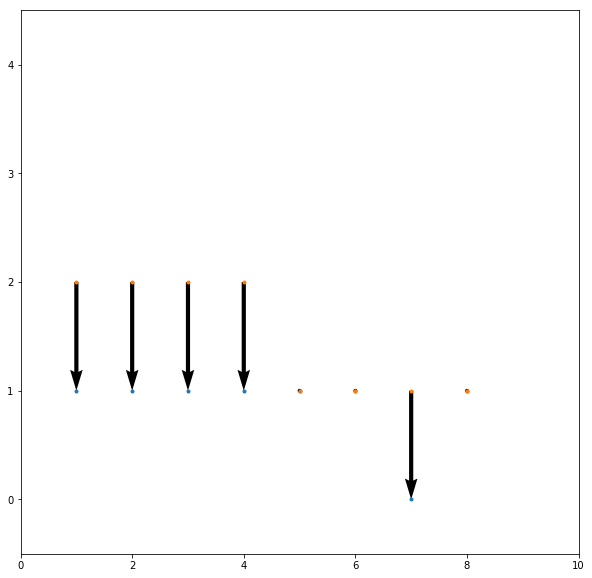

In [19]:
graph.quiver_snodes()
print(gtimer)

# Replay schedule

In [20]:
N_fullstep = 500
dt_vis = 0.01
for schedule in schedule_sorted:
    print(schedule)
for schedule, i_s in zip(schedule_sorted[:1], range(len(schedule_sorted))):
    e, end_state, success = graph.simulate_transition(
        graph.snode_dict[0].state, graph.snode_dict[0].state, 
        N=10, dt=dt_sim, vel_conv=1e-2, err_conv=5e-4)
    timer.sleep(0.1)
#     try:
    e = graph.replay(schedule, N=N_fullstep, dt=dt_vis, N_step=N_fullstep, 
                     vel_conv=1e-2, err_conv=1e-3, error_skip=0)
#     except Exception as e:
#         print(e)

[0, 1, 6, 7]

--------------------
1-(('box1', 'bottom_p', 'grip1'),)

--------------------
6-(('box1', 'front_p', 'vac2'),)

--------------------
7-(('box1', 'back_p', 'goal_bd'),)


# Execute traj online

In [46]:
schedule = schedule_sorted[0]
state_schedule = graph.idxSchedule2stateScedule(schedule, ZERO_JOINT_POSE)
obs_names = ["box3"]

with DynamicDetector(obs_names, aruco_map, dictionary, rs_config, T_c12, objectPose_dict['floor']) as dynamic_detector, \
        RvizPublisher(graph, obs_names) as rviz_pub:
    graph.execute_schedule_online(state_schedule, control_freq=DEFAULT_TRAJ_FREQUENCY, playback_rate=0.5,
                                  vel_conv=1e-2, err_conv=1e-3, T_step = 50, on_rviz=True, 
                                  obs_names=obs_names, dynamic_detector=dynamic_detector, rviz_pub=rviz_pub)

AttributeError: ConstraintGraph instance has no attribute 'indy'

# onestep

In [39]:
def loop_process():
    loop_process.stop_now = False
    while not loop_process.stop_now:
        print("wait for button input")
        graph.indy.connect_and(graph.indy.wait_di, 16)
        if loop_process.stop_now:
            break
        kn_config, rs_config, T_c12 = calibrate_stereo(aruco_map, dictionary)
        objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
            detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
        objectPose_dict_mv.update({'floor': objectPose_dict['floor']})
        xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
            objectPose_dict_mv, MOVABLE_GENERATORS, OBJECT_DICT, ("floor", objectPose_dict["floor"]))
        update_geometries(MOVABLE_GENERATORS.keys(), objectPose_dict_mv)
        graph.show_pose(ZERO_JOINT_POSE)
        
        dt_sim = 0.04
        T_step = 10
        N_fullstep = int(T_step / dt_sim)
        gtimer.reset()
        initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                              {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                              (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                               else ZERO_JOINT_POSE))

        goal_nodes = get_goal_nodes(initial_state, "box1", "goal_bd")

        graph.search_graph_mp(
            initial_state = initial_state, goal_nodes = goal_nodes,
            tree_margin = 2, depth_margin = 2, joint_motion_num=10, 
            terminate_on_first = True, N_search = 100, N_loop=1000,
            display=False, dt_vis=dt_sim/40, verbose = True, print_expression=False, error_skip=0,
            **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-2, err_conv=1e-3, N_step=N_fullstep))

        schedule_dict = graph.find_schedules()
        schedule_sorted = graph.sort_schedule(schedule_dict)

        schedule = schedule_sorted[0]
        state_schedule = graph.idxSchedule2stateScedule(schedule, ZERO_JOINT_POSE)
        obs_names = ["box3"]

        with DynamicDetector(obs_names, aruco_map, dictionary, rs_config, T_c12, objectPose_dict['floor']) as dynamic_detector, \
                RvizPublisher(graph, obs_names) as rviz_pub:
            graph.execute_schedule_online(state_schedule, control_freq=DEFAULT_TRAJ_FREQUENCY, playback_rate=0.5,
                                          vel_conv=1e-2, err_conv=1e-3, T_step = 50, on_rviz=False, 
                                          obs_names=obs_names, dynamic_detector=dynamic_detector, rviz_pub=rviz_pub)
    print("===========================================")
    print("=================KILLED====================")
    print("===========================================")
t_loop = Thread(target=loop_process)
t_loop.start()

wait for button input
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
unknown eTaSL exception: optimization failed during execution

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.44 s, err: 0.685238307896)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'back_p', 'grip1'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (0.98 s, err: 0.000952943417618)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.1 s, err: 0.130097449087)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.28 s, err: 0.0730680494845)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.43 s, err: 0.0751908029837)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1


fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.86 s, err: 0.0931139914436)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.92 s, err: 0.22433769414)======================================================================================================================================================

node: (('box1', 'left_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (1.97 s, err: 0.0311672527169)
node: (('box1', 'right_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (2.43 s, err: 0.523912952039)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'front_p', 'goal_bd'),)

success - Goal cost:1->0 / Init cost:1->2 / branching: 2->4 (2.49 s, err: 0.000878074632719)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

success - Goal cost:1->0 / Init cost:1->2 / branching:


fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.77 s, err: 1.07132624998)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'front_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.83 s, err: 0.178718802768)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (2.9 s, err: 0.359958114867)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (3.03 s, err: 0.0953188927428)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (3.16 s, err: 1.17258966935)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (3.34 s, err: 0.00171795120759)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> 


fail - Goal cost:1->1 / Init cost:1->1 / branching: 4-> (6.21 s, err: 0.691332443556)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 4-> (6.26 s, err: 0.471464976741)node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'bottom_p', 'grip1'),)

node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (6.29 s, err: 0.909561308472)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 4-> (6.32 s, err: 0.262940680292)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'bottom_p', 'grip1'),)

node: (('box1', 'right_p', 'grip1'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 4-> (6.36 s, err: 1.43676829991)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 4-> (6.38 s, err: 0.132767984117)======================================================================================================================================================
node: (('box1', 'bottom_p', 'grip1'),)-

In [40]:
loop_process.stop_now=True

In [41]:
t_loop.is_alive()

True

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
ax = plt.plot(qcount_indy_list)
ax = plt.plot(qcount_panda_list)
plt.subplot(1,2,2)
ax = plt.plot(looptime_list)
print(gtimer)

# Going back

In [133]:
e_POS = e_POS_list[0]
self.panda.move_joint_interpolated(
    e_POS[0, graph.panda_idx], N_step=500, N_div=500)

In [35]:
e_POS = e_POS_list[0]
if hasattr(graph, 'indy'):
    graph.indy.joint_move_to(np.rad2deg(e_POS[0,graph.indy_idx]))

In [38]:
self.reset_panda()

# test mesh

In [16]:
from pkg.gjk import *

In [21]:
Q1 = ZERO_JOINT_POSE
Q2 = ZERO_JOINT_POSE - 0.1

gtimer.reset()

gtimer.tic("svt")
swept_volume_test(Q1, Q2, graph.fixed_collision_items_list+graph.movable_collision_items_list, 
                  graph.joint_names, graph.urdf_content)
gtimer.toc("svt")

17.860889434814453

panda1_rightfinger_Mesh_0
pole_cam1


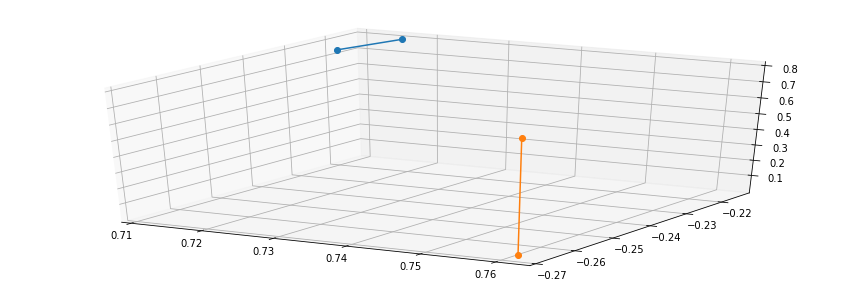

In [130]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

fig = plt.figure(figsize=(15, 5))

idx_col = 205

sub = fig.add_subplot(1, 1, 1, projection="3d")
x, y, z = np.transpose(vtx2_list[idx1_list[idx_col]])
sub.plot(x, y, z, '-o')
x, y, z = np.transpose(vtx2_list[idx2_list[idx_col]])
print(GeometryItem.GLOBAL_GEO_LIST[idx1_list[idx_col]].name)
print(GeometryItem.GLOBAL_GEO_LIST[idx2_list[idx_col]].name)
sub.plot(x, y, z, '-o')
# sub.view_init(0, 90)

In [25]:
# np.save("vtx_list", vtx_list)
# np.save("radius_list", radius_list)
# np.save("idx1_list", idx1_list)
# np.save("idx2_list", idx2_list)